This is a Bayesian hierarchical (pooling) model for movie ratings.  Each movie can be rated on a scale from zero to five.  Each movie is rated several times.  We want to find a smoothed distribution of ratings for each movie.

We are going to learn a top-level prior distribution (hyperprior) on movie ratings from the data.  Each movie will then have its own prior that is smoothed by this top-level prior.  Another way of thinking about this is that the prior for ratings for each movie will be shrunk towards the group-level, or pooled, distribution.

If a movie has an atypical rating distribution, this approach will shrink the ratings to something more in-line with what is expected.  Furthermore, this learned prior can be useful to bootstrap movies with few ratings to allow them to be meaningfully compared to movies with many ratings.

The model is as follows:

$\gamma_{k=1...K} \sim Gamma(\alpha, \beta)$

$\theta_{m=1...M} \sim Dirichlet_M(c\gamma_1, ..., c\gamma_K)$

$z_{m=1...M,n=1...N_m} \sim Categorical_M(\theta_m)$

where:

* $K$ number of movie rating levels (e.g. $K = 6$ implies ratings 0, ..., 5)
* $M$ number of movies being rated
* $N_m$ number of ratings for movie $m$ 
* $\alpha = 1 / K$ in order to make the collection of gamma r.v.s [act as an exponential coefficient](http://tdunning.blogspot.com/2010/04/sampling-dirichlet-distribution-revised.html)
* $\beta$ rate parameter for the exponential top-level prior
* $c$ concentration parameter dictating the strength of the top-level prior
* $\gamma_k$ top-level prior for rating level $k$
* $\theta_m$ movie-level prior for rating levels (multivariate with dimension = $K$)
* $z_{mn}$ rating $n$ for movie $m$

In [1]:
# uses pymc3
import numpy as np
import pymc3 as pm
import scipy.stats
import matplotlib.pyplot as plt

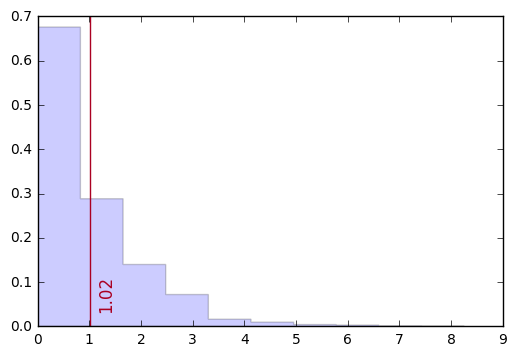

In [2]:
# show the exponential distribution coefficient prior for
# the movie-level priors and the impact on the choice of
# the rate parameter

# when alpha (a) is 1, then the gamma distribution is an
# exponential distribution with rate parameter 1 / scale
samples = scipy.stats.gamma.rvs(a=1., scale=1., size=2000)

# the exponential distribution mean is equal to its inverse
# rate parameter
mean = samples.mean()

plt.hist(samples, normed=True, histtype="stepfilled", alpha=.2)
plt.axvline(mean, color="#AA0022")
plt.annotate("{:.2f}".format(mean), xy=(mean,0), xycoords="data" ,xytext=(5,10),
    textcoords="offset points", rotation=90, va="bottom", fontsize="large", color="#AA0022")
plt.show()

In [3]:
# this array stores the counts of each rating for each
# movie where each row corresponds to a movie and each
# column corresponds to counts for a rating at that level
data = np.array([
    [ 0, 0, 0, 0, 0, 2 ], # Movie 1 with 2 5-star ratings
    [ 0, 0, 0, 0, 1, 4 ], # Movie 2 with 1 4-star rating and 4 5-star ratings
    [ 0, 1, 1, 2, 4, 2 ], # ...
    [ 0, 3, 3, 6, 12, 6 ],
    [ 0, 0, 2, 4, 5, 1 ],
    [ 0, 1, 3, 3, 2, 1 ],
    [ 1, 0, 4, 4, 1, 2 ],
])

# rate hyperparameter for the exponential coefficient
rate = 1.

# concentration hyperparameter dictating how much effect
# the top-level hyperprior has on individual movies
concentration = 1.

In [4]:
(numberOfMovies, numberOfRatingLevels) = data.shape

model = pm.Model()

model.verbose = 0

with model:
    # top-level prior
    gamma = []
    
    alpha = 1. / numberOfRatingLevels
    
    for k in range(numberOfRatingLevels):
        gamma_k = pm.Gamma("gamma_%i" % k, alpha=alpha, beta=rate)
        
        gamma_k = gamma_k * concentration
        
        gamma.append(gamma_k)
        
    # each movie
    for m in range(numberOfMovies):
        # sample the Dirichlet by sampling from gammas and normalizing
        theta_m = []
        
        for k in range(0, numberOfRatingLevels):
            theta_mk = pm.Gamma("theta_%i%i" % (m, k), alpha=gamma[k], beta=1.)
        
            theta_m.append(theta_mk)
            
        theta_m = theta_m / np.sum(theta_m)

        # rating counts for the movie
        ratingCounts = data[m]
        
        # use a multinomial to achieve repeated categorical draws
        phi_m = pm.Multinomial("phi_%i" % m, n=ratingCounts.sum(), p=theta_m, observed=ratingCounts)
        
    # use the Metropolis sampler as the NUTS sampler doesn't like this model
    step = pm.Metropolis()
    
    # obtain 3000 samples
    trace = pm.sample(3000, step=step)

100%|������������������������������| 3000/3000 [00:20<00:00, 149.70it/s]


In [5]:
# get the mean sample values of the last 2000 samples
sampleMeans = np.array(pm.df_summary(trace[-2000:])['mean'])

# the first variables correspond to gamma and the rest
# correspond to each theta_m
sampleMeans = sampleMeans.reshape((numberOfMovies + 1, numberOfRatingLevels))

# normalize these to be the parameters of a multinomial
# distribution and in the case of gamma, it would be the
# expected value for draws from a Dirichlet with these
# parameters
for i in range(numberOfMovies + 1):
    sampleMeans[i] = sampleMeans[i] / sampleMeans[i].sum()

# our infererred parameter estimates
gamma_ = sampleMeans[0]

theta_m_ = sampleMeans[1:]

# some additional statistics for comparison
normalizedRatingCounts = np.array(data, np.float64)

normalizedRatingCountMeans = normalizedRatingCounts.sum(axis=0)

normalizedRatingCountMeans = normalizedRatingCountMeans / normalizedRatingCountMeans.sum()

for i in range(numberOfMovies):
    normalizedRatingCounts[i] = normalizedRatingCounts[i] / normalizedRatingCounts[i].sum()

normalizedRatingCountStds = normalizedRatingCounts.std(axis=0)

ratingCountSums = data.sum(axis=0)

# compute the average ratings
levels = np.diag(np.arange(numberOfRatingLevels))

maximumLikelihoodRatingAverages = np.dot(normalizedRatingCounts, levels).sum(axis=1)

inferredRatingAverages = np.dot(theta_m_, levels).sum(axis=1)

In [6]:
print """
Comparing the top-level prior parameter estimate and the maximum-likelihood estimate
shows how the model is pooling the data."""

print """
Original data (movies x rating counts):
"""
print data

print """
Top-level prior parameters (the pooled estimate of the probability of chosing a rating):
"""
print gamma_

print """
Maximum-likelihood probability of chosing a rating from the raw count data:
"""
print normalizedRatingCountMeans

print """
Total counts for each rating:
"""
print ratingCountSums

print """
Standard deviation for the normalized rating counts across all movies:
"""
print normalizedRatingCountStds

print """
Estimates for ratings 3, 4, and 5 show how the model accounts for lower / higher
number of counts and lower / higher standard deviation in forming its pooled estimate.

Estimates for ratings 0 and 1 show how the model accounts for low numbers of counts."""


Comparing the top-level prior parameter estimate and the maximum-likelihood estimate
shows how the model is pooling the data.

Original data (movies x rating counts):

[[ 0  0  0  0  0  2]
 [ 0  0  0  0  1  4]
 [ 0  1  1  2  4  2]
 [ 0  3  3  6 12  6]
 [ 0  0  2  4  5  1]
 [ 0  1  3  3  2  1]
 [ 1  0  4  4  1  2]]

Top-level prior parameters (the pooled estimate of the probability of chosing a rating):

[ 0.02406627  0.07585432  0.17492069  0.22285698  0.250879    0.25142274]

Maximum-likelihood probability of chosing a rating from the raw count data:

[ 0.01234568  0.0617284   0.16049383  0.2345679   0.30864198  0.22222222]

Total counts for each rating:

[ 1  5 13 19 25 18]

Standard deviation for the normalized rating counts across all movies:

[ 0.02916059  0.04948717  0.12307474  0.13384256  0.15478022  0.34554174]

Estimates for ratings 3, 4, and 5 show how the model accounts for lower / higher
number of counts and lower / higher standard deviation in forming its pooled estimate

In [7]:
print """
Comparing the inferred estimates of the probability of chosing a rating for
individual movies against the respective maximum-likelihood estimates is
also informative."""

print """
Rating count data for movies 1 and 2 below.  Movie 1 has less than half the
ratings as movie 2 but all of its ratings are 5-star.  Movie 2 has more
5-star ratings but also one 4-star rating.  The maximum-likelihood estimate
would ignore the number of ratings and focus on the proportions.  The smoothed
inferred estimate accounts for the number of ratings and also applies the
pooled prior estimate of the rating probabilities.
"""

print data[0:2]

print """
Maximum-likelihood rating probability estimates for movies 1 and 2:
"""
print normalizedRatingCounts[0:2]

print """
Inferred rating probability estimates for movies 1 and 2:
"""
print theta_m_[0:2]

print """
The inferred estimate places higher probability on chosing a 5-star
rating for movie 2 versus movie 1 as opposed to the maximum-likelihood
probability.
"""


Comparing the inferred estimates of the probability of chosing a rating for
individual movies against the respective maximum-likelihood estimates is
also informative.

Rating count data for movies 1 and 2 below.  Movie 1 has less than half the
ratings as movie 2 but all of its ratings are 5-star.  Movie 2 has more
5-star ratings but also one 4-star rating.  The maximum-likelihood estimate
would ignore the number of ratings and focus on the proportions.  The smoothed
inferred estimate accounts for the number of ratings and also applies the
pooled prior estimate of the rating probabilities.

[[0 0 0 0 0 2]
 [0 0 0 0 1 4]]

Maximum-likelihood rating probability estimates for movies 1 and 2:

[[ 0.   0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0.2  0.8]]

Inferred rating probability estimates for movies 1 and 2:

[[ 0.02144172  0.05540504  0.12788657  0.16527906  0.18168197  0.44830564]
 [ 0.01063829  0.04511137  0.09015204  0.11610496  0.22394176  0.51405158]]

The inferred estimate 

In [8]:
print """
Rating count data for movies 3 and 4 below.  Movies 3 and 4 have identical
rating count proportions (and identical maximum-likelihood estimates) but
movie 4 has three times as many ratings as movie 3.  The higher number
of ratings should push the inferred estimate of movie 4 closer to the
maximum- likelihood estimate as it should start to dominate the prior.
"""

print data[2:4]

print """
Maximum-likelihood rating probability estimates for movies 3 and 4:
"""
print normalizedRatingCounts[2:4]

print """
Inferred rating probability estimates for movies 3 and 4:
"""
print theta_m_[2:4]

print """
The inferred estimate for movie 4 is closer to the maximum-likelihood
estimate as we would expect given its higher number of overall counts.
"""


Rating count data for movies 3 and 4 below.  Movies 3 and 4 have identical
rating count proportions (and identical maximum-likelihood estimates) but
movie 4 has three times as many ratings as movie 3.  The higher number
of ratings should push the inferred estimate of movie 4 closer to the
maximum- likelihood estimate as it should start to dominate the prior.

[[ 0  1  1  2  4  2]
 [ 0  3  3  6 12  6]]

Maximum-likelihood rating probability estimates for movies 3 and 4:

[[ 0.   0.1  0.1  0.2  0.4  0.2]
 [ 0.   0.1  0.1  0.2  0.4  0.2]]

Inferred rating probability estimates for movies 3 and 4:

[[ 0.00738755  0.09079506  0.12985281  0.20999552  0.3488494   0.21311968]
 [ 0.00366227  0.09739613  0.10971591  0.2088047   0.36784195  0.21257903]]

The inferred estimate for movie 4 is closer to the maximum-likelihood
estimate as we would expect given its higher number of overall counts.



In [9]:
print """
To compute an average rating for each movie, a maximum-likelihood
approach could be used (in this case an average) or the inferred
rating probabilities can be used."""

print """
Raw movie rating count data for reference (movie x rating counts):
"""
print data

print """
Maximum-likelihood estimate of rating for each movie:
"""
print maximumLikelihoodRatingAverages

print """
Inferred estimate of rating for each movie:
"""
print inferredRatingAverages

print """
The inferred estimate for movie 2 is higher than movie 1 as
expected compared to the maximum-likelihood estimates because
of the higher number of overall ratings for movie 2."""

print """
The inferred estimate for movie 4 moves closer to the
maximum-likelihood estimate than movie 3 as expected because
of the  higher number of ratings (the influence of the prior
can be changed with the concentration parameter)."""

print """
The inferred estimate for movie 7 is increased relative to
the maximum-likelihood estimate despite the presence of a
zero rating."""


To compute an average rating for each movie, a maximum-likelihood
approach could be used (in this case an average) or the inferred
rating probabilities can be used.

Raw movie rating count data for reference (movie x rating counts):

[[ 0  0  0  0  0  2]
 [ 0  0  0  0  1  4]
 [ 0  1  1  2  4  2]
 [ 0  3  3  6 12  6]
 [ 0  0  2  4  5  1]
 [ 0  1  3  3  2  1]
 [ 1  0  4  4  1  2]]

Maximum-likelihood estimate of rating for each movie:

[ 5.          4.8         3.5         3.5         3.41666667  2.9
  2.83333333]

Inferred estimate of rating for each movie:

[ 3.77527145  4.03975528  3.44148319  3.47750503  3.39474854  3.09424091
  3.00101262]

The inferred estimate for movie 2 is higher than movie 1 as
expected compared to the maximum-likelihood estimates because
of the higher number of overall ratings for movie 2.

The inferred estimate for movie 4 moves closer to the
maximum-likelihood estimate than movie 3 as expected because
of the  higher number of ratings (the influence of the p